# PIC 16B Final Project
### By:  Artem Kiryukhin and Karl Puttler

For this project we plan to use a dataset of 87,000 images of various American Sign Language hand signs to train a model which could accurately translate the hand signs to their appropriate meanings. We believe that this project could be a stepping stone to create a more inclusive environment for deaf people, a demographic that makes up over half a million people in the US. In addition to potentially making an impact for the deaf community we want to use the knowledge that we obtained from our math degrees to implement linear algebra and various mathematical imaging techniques (e.g. convolution) in a practical manner.

In order to complete this project we will utilize the aforementioned dataset (https://www.kaggle.com/datasets/grassknoted/asl-alphabet).



Below we import the necessary libraries

In [1]:
from tqdm import tqdm
import numpy as np
import torch
# import torch.nn as nn
# from torchvision import transforms, datasets
# from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
# from PIL import Image
# from IPython.display import Image as Img
from sklearn.metrics import confusion_matrix
import seaborn as sns

from dataProcessing import *
from models import *

Since we wanted to work with our trained model and not necessarily train a new one every single time we worked in this file we implemented simple lambda functions to handle saving and loading the model parameters.

In [3]:
# save and load model functions
save_model = lambda model, name: torch.save(model.state_dict(), name)
load_model = lambda model, name: model.load_state_dict(torch.load(name))

These are just some parameters for our data loading functions.

In [2]:
# set device to gpu if available and cpu if not
G_DEVICE            = torch.device("cuda") or torch.device("cpu")
G_BATCH_SIZE        = 128
G_NUM_WORKERS       = 16
G_TEST_IMG_PATH     = "ASL_Data/asl_alphabet_test/asl_alphabet_test"
G_TRAIN_IMG_PATH    = "ASL_Data/asl_alphabet_train/asl_alphabet_train"

## LeNet

LeNet5 was a model that was designed in 1998 by Yann LeCun and his colleagues. This model was one of the pioneering CNN models and proved to be incredibly effective. The model utilizes 2 convolutional layers, 2 maxpooling layers, and 3 fully connected layers. Overall we decided to implement this model because of its simplicity and the small amount of parameters (60,000). We modified the model slightly, firstly we changed the number of outputs to 29 (26 letters + 3 symbols) and added a dropout layer with 50% rate to help the model generalize better. An important point to note is that the model takes in inputs of 32x32x3 which means that we had to compress the images making them lose some of their details.

### Visualizing the Processed Images
We needed to make convert our images into a data format which the model can be trained upon. We used PyTorch transforms for this purpose. Firstly we resized the images into 32x32 so they can be valid inputs for LeNet5. Next we tensorized them so they are stored as a tensor of numerical values for each pixel. Lastly we standarized the data to promote faster gradient descent convergence.

The code below loads one batch from the train_loader object we defined in the dataProcessing file of this project. This object is created using the DataLoader class from PyTorch. Thanks to this class we do not need to worry about manually shuffling, batching, and loading the data. In addition to loading a single batch we define a list of label names to display instead of the numerical labels that the data has right now. Finally we itterate through a couple of samples and display the images that we will be inputting into our model.Notice the strange colors, these are due to standardization we performed on the pixel values of the images.

In [4]:
# load data for LeNet
train_loader, test_loader = split_dataloaders(G_TRAIN_IMG_PATH, train_size = 0.8, batch_size = G_BATCH_SIZE, num_workers = G_NUM_WORKERS, transform = train_transform_le)

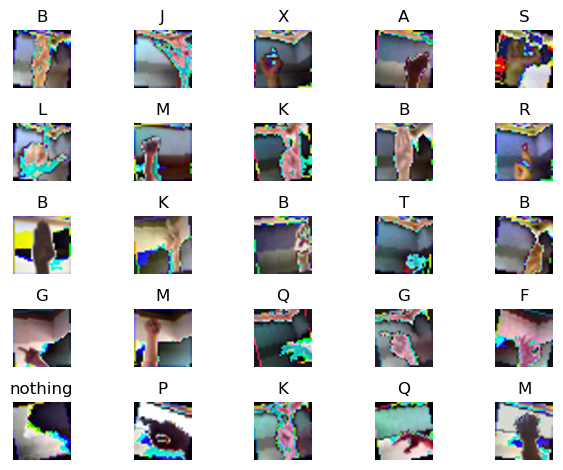

In [5]:
# load data to display
train_loader, test_loader = split_dataloaders(G_TRAIN_IMG_PATH, train_size = 0.8, batch_size = G_BATCH_SIZE, num_workers = G_NUM_WORKERS, transform = train_transform_le)

# loads one batch of training data
batch = next(iter(train_loader)) 

# creates a list of labels
labels_names = [chr(ord('A') + i) for i in range(26)]
labels_names.extend(["del","nothing","space"])

# displays grid of images and their labels
for i in range(25):
    
    image = transforms.ToPILImage()(batch[0][i])
    label = labels_names[batch[1][i].item()]
    resized_image = image.resize((256, 256))

    # plots the images and labels in a grid
    plt.subplot(5, 5, i + 1)
    plt.imshow(resized_image)
    plt.axis('off')
    plt.title(label )
    
plt.tight_layout()
# save the figure
plt.savefig("LeNetTransforms.png")

### Training and Accuracy Functions

Below are the functions we created for getting the accuracy of our model and to actually train the model. Let's walk through the inner mechanisms of each. 

The evaluate() function works by calculating how predictions are equal to the true label of the image for each batch, in other words how many did the model predict right. Then it simply divides this number by the amount of images are in the data set, multiplies it by a 100, and voila there is the model's accuracy.  Additionally this also gets the average loss function value per batch. We get the average since the train dataset has more batches and hence a cumulative function will produce artificially large loss values for the train data. Important note to use torch.no_grad() in order to make sure that none of our calculation interfere with gradient values later on.

The train model is slightly more complex, though it is nothing out of the ordinary. During the function runtime we unpack each batch into image pixels and labels, next we get the prediction of the current model and use those to calculate the loss. For the loss function we use CrossEntropyLoss which is standard for multi-class classification problems like we have here. After we get the loss we calculate the gradients with respect to each weight by calling loss.backward() and then perform an update rule via the optimizer class. Additionally we use the same logic to get the accuracy as we do in the evaluate() function.

In [6]:
def evaluate(model, test_loader, loss_criteria):
    """
    Tests the model's accuracy

    @params:
        model: pytorch nn.Module, model to evaluate
        test_loader: pytorch DataLoader, data to evaluate on
        loss_criteria: pytorch loss function, loss function

    @returns:
        (accuracy, test_loss) floats representing the percentage accuracy and average loss
    """
    
    # Sets model to eval mode
    model.eval()

    correct = 0
    test_loss = 0
    total_samples = 0
    
    with torch.no_grad():

        for data, label in test_loader:
            # Move data, label to device
            data = data.to(G_DEVICE)
            label = label.to(G_DEVICE)
            
            # Model's prediction
            output = model(data)
            
            # Calculate the number of correct responses in current batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(label==predicted).item()
            test_loss += loss_criteria(output, label).item()
            total_samples += data.size(0)
    
    # Get average loss
    test_loss = test_loss / total_samples
    # Get accuracy
    accuracy = round((100 * correct / len(test_loader.dataset)),2)
    
    return (accuracy, test_loss)

In [7]:
def train(model, train_loader, test_loader, optimizer, loss_criteria, epoch):
    """
    Trains the model parameters and returns average loss and percentage accuracy 
    
    @params:
        model - pytorch model to train
        train_loader - dataLoader object w/ training data
        test_loader - dataLoader object w/ testing data
        optimizer - pytorch optimizer object
        loss_criteria - pytorch loss criteria
        epoch - what the current epoch is
    
    @returns:
        (train_loss, test_loss, train_acc, test_acc) each a float 
    """
    
    # sets the model to training mode
    model.train()
    loss_tracker = 0
    correct = 0
    total_samples = 0
    
    # progress bar
    train_loader_iter = tqdm(train_loader, desc = f"Epoch {epoch + 1}")
    
    
    for data, label in train_loader_iter:

        data = data.to(G_DEVICE)
        label = label.to(G_DEVICE)

        # resets the gradients
        optimizer.zero_grad()
        
        # model's current prediction
        prediction = model(data)
        
        # tracks loss
        loss = loss_criteria(prediction, label)
        loss_tracker += loss.item()
        total_samples += data.size(0)
        
        # calculates gradient
        loss.backward()
        optimizer.step()
        
        # accuracy
        _, predicted = torch.max(prediction.data, 1)
        correct += torch.sum(label == predicted).item()
        
    # get training accuracy and average training loss
    train_acc = round((100 * correct / len(train_loader.dataset)), 2)
    train_loss =  loss_tracker / total_samples
    
    # get test accuracy and average loss
    test_acc, test_loss = evaluate(model, test_loader, loss_criteria)
        
    return (train_loss, test_loss, train_acc, test_acc)  

### Defining Parameters
Below we define our learning rate, epochs, and empty lists with loss and accuracy values. Additionally we initialize the model, optimizer, and the loss function.

Through trial and error of using a subset dataset we found that the more or less default learning rate of 0.001 was actually optimal for our training. Any larger values produced gradient steps that were too large and the model would overstep the global minimum. Additionally we chose the Adam optimizer since it helps use momentum to optimize the weights quicker, something we value greatly since our resources are limited and training models for a long time is quite constraining. 

In [8]:
learning_rate = 0.001
epochs = 30
lenet_train_losses = []; lenet_test_losses = []; 
lenet_train_accuracies = []; lenet_test_accuracies = []

# Perform workflow with LeNet
lenet = LeNet5().to(G_DEVICE)
optimizer = optim.Adam(lenet.parameters(), lr = learning_rate)
loss_criteria = nn.CrossEntropyLoss().to(G_DEVICE)

### Training the Model
This code simply calls the train function epoch amount of times and appends the accuracies and loss values. 

In [9]:
for epoch in range(epochs):
    # get metrics
    train_loss, test_loss, train_accuracy, test_accuracy = train(lenet, train_loader, test_loader, optimizer, loss_criteria, epoch)

    # populate arrays containing metric by epoch
    lenet_train_losses.append(train_loss)
    lenet_test_losses.append(test_loss)
    lenet_train_accuracies.append(train_accuracy)
    lenet_test_accuracies.append(test_accuracy)

Epoch 30: 100%|██████████| 544/544 [00:04<00:00, 112.49it/s]


### Plotting Performance

To understand the model better we should visualize its training process. Below are the graphs of histories of loss function and accuracy over epochs. A strange phenomena occurs in the accuracy graph, the model performs significantly better on the test data compared to the training data! This can be explained by the fact that our training data utilizes data augmentation. With the augmented data the training data is messier and more difficult for the model to predict correctly, while the test data is simple and clean so the model does extremely well.

In [10]:
def make_plots(file_name, train_losses, test_losses, train_accuracies, test_accuracies):
    """
    Creates a losses and accuracies plots and saves them to specified file name.

    @params:
        file_name: string, name with which to save plot 
        train_losses: list of floats
        test_losses: list of floats
        train_accuracies: list of floats
        test_accuracies: list of floats
    """
    # create subplots
    fig, ax = plt.subplots(1, 2, figsize = (20, 8))
    
    # plot the losses
    ax[0].plot(np.arange(1, epochs + 1), train_losses, label = "Train Loss")
    ax[0].plot(np.arange(1, epochs + 1), test_losses, label = "Test Loss")
    ax[0].set(title = "Losses over Epochs", ylabel = "Loss", xlabel = "Epoch")
    ax[0].set_xticks(np.arange(1, epochs + 1, 3));
    ax[0].legend(loc = "upper right")

    # plot the accuracies
    ax[1].plot(np.arange(1,epochs + 1), train_accuracies, label = "Train Accuracy")
    ax[1].plot(np.arange(1,epochs + 1), test_accuracies, label = "Test Accuracy")
    ax[1].set(title = "Accuracies over Epochs", ylabel = "Accuracy %", xlabel = "Epoch")
    ax[1].set_xticks(np.arange(1, epochs + 1, 3));
    ax[1].legend(loc = "upper right")

    # save plot
    plt.savefig(file_name, format="png")

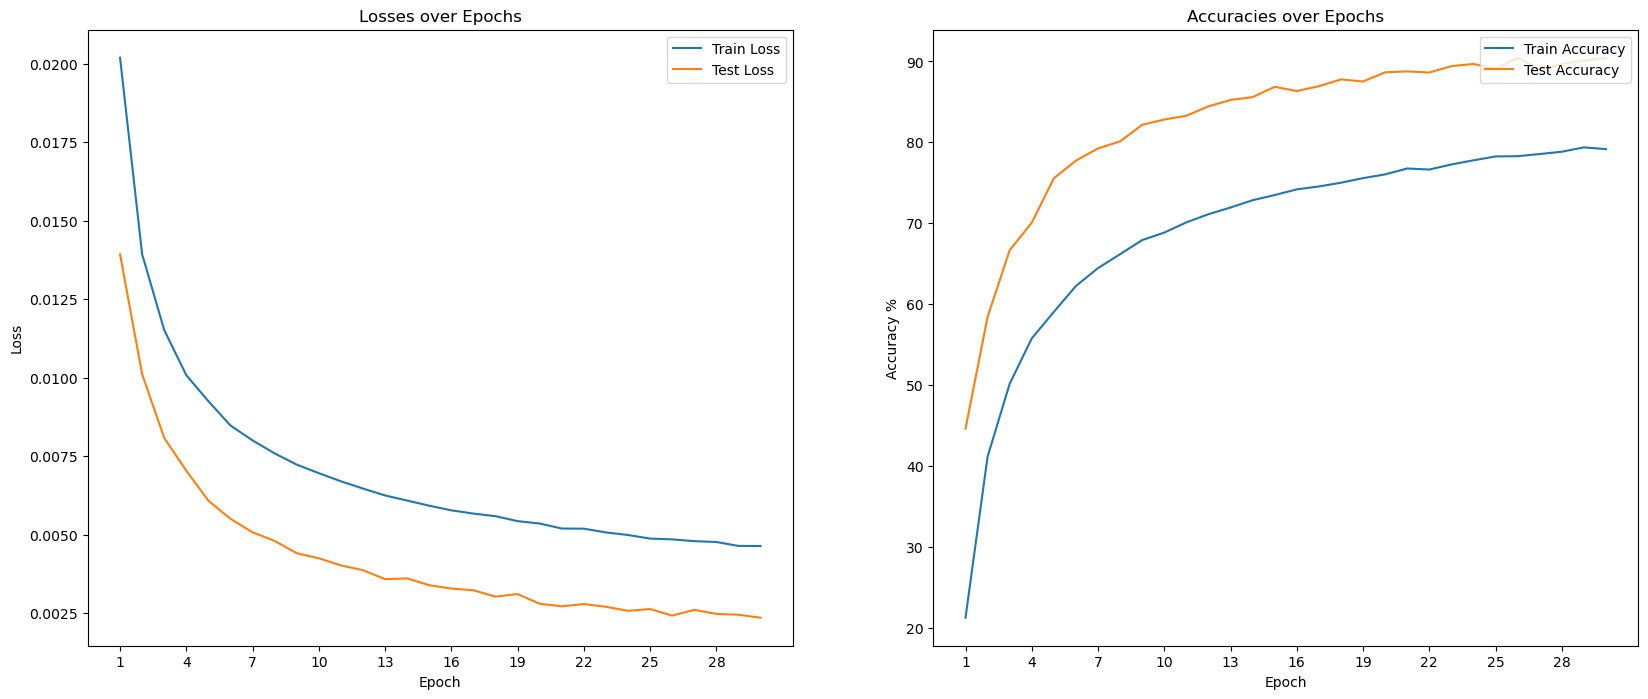

In [11]:
# save and show the plot for LeNet
make_plots("LeNet30EpochHistory.png", lenet_train_losses, lenet_test_losses, lenet_train_accuracies, lenet_test_accuracies)

The code below is for testing purposes rn. Also currently the validation set is more or less used as a test so maybe we abolish the test_loader all together...

In [12]:
# save the LeNet model weights
save_model(lenet, "LeNet30Epoch.pth")

In [13]:
lenet_accuracy, lenet_loss = evaluate(lenet, test_loader = test_loader, loss_criteria = loss_criteria)
print(f"LENET ACCURACY {lenet_accuracy} LOSS {lenet_loss}")

LENET ACCURACY 90.19 LOSS 0.00237689483672067


### Confusion Matrix

Below we create a confusion matrix. This showcases the true labels on the y-axis and the predicted ones on the x-axis. Visually this tells us where the model gets confused and leads us to investigate some probelms within our plans. For example we can see that when the true label is "A" it predicts "E" and "S" frequently, this is due to the fact that all three of these letters are just a fist with different thumb positioning so even a human would struggle time to time.

In [14]:
def create_confusion_matrix(file_name, model, test_loader):
    """ 
    Creates a confusion matrix given a model and a dataLoader object
    
    @params:
        model: pytorch nn.Module, model for which the matrix is made
        test_loader: pytorch dataloader, data with which the matrix is made
    """
    
    # sets the model to eval mode
    model.eval()

    labels_list = []
    predicted_list = []
    
    with torch.no_grad():
    
        for data, label in test_loader:
            # fills the labels and predictions
            labels_list.extend(label.numpy())
            # convert to device to calculate
            data = data.to(G_DEVICE)
            label = label.to(G_DEVICE)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            # convert back to cpu to do numpy
            predicted_list.extend(predicted.cpu().numpy())
            
    # construct the confusion matrix 
    conf_matrix = confusion_matrix(labels_list, predicted_list)
    
    # creates a sns heatmap with the conf matrix
    plt.figure(figsize=(14, 10))
    sns.heatmap(conf_matrix, annot = True, cmap = 'Blues', fmt = 'g', 
            xticklabels = labels_names, yticklabels = labels_names, vmax = 100)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # saves the figure
    plt.savefig(file_name, format = "png")

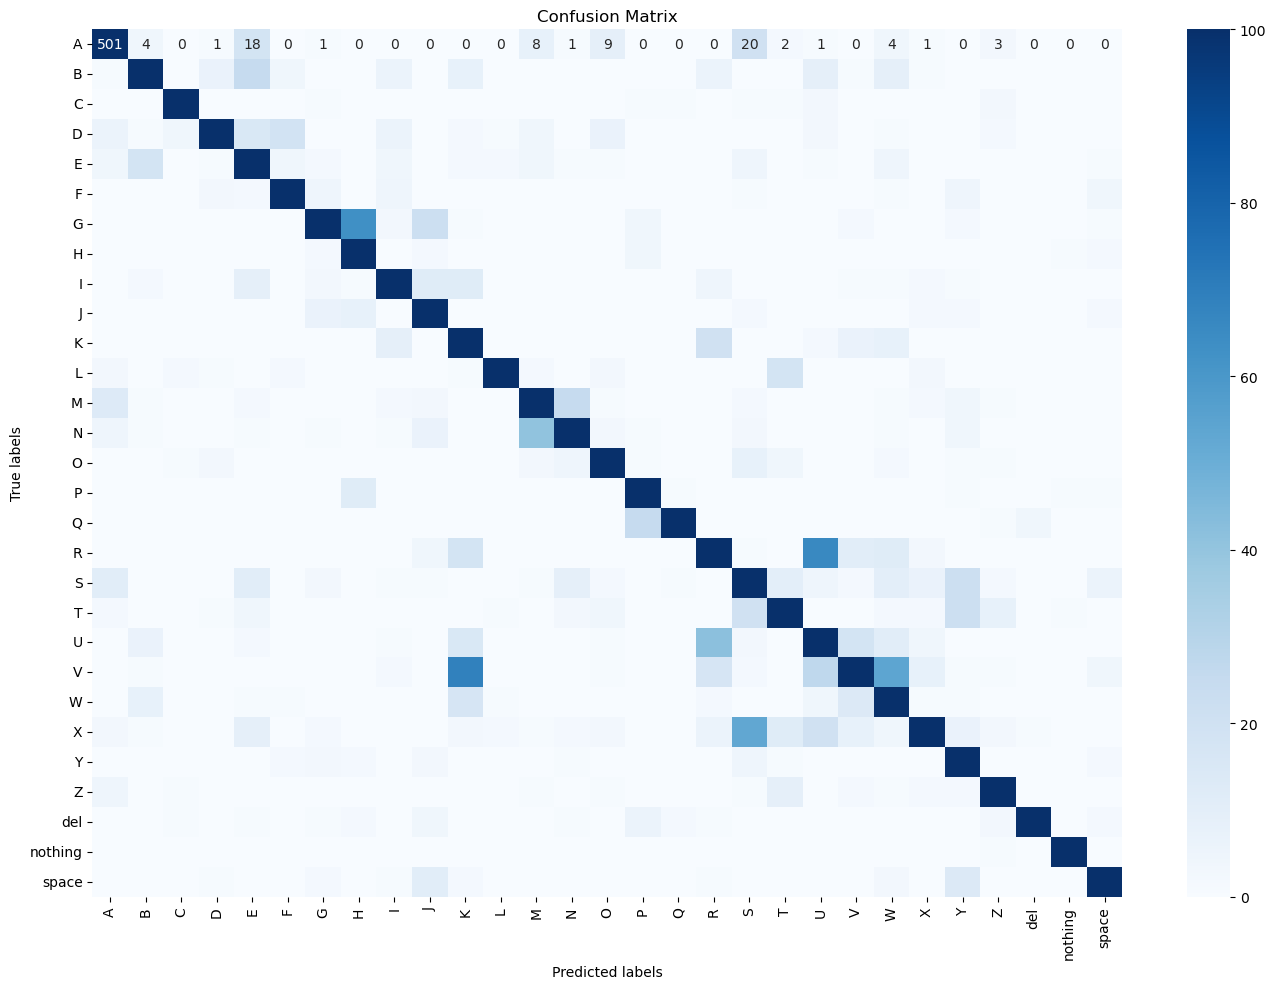

<Figure size 640x480 with 0 Axes>

In [15]:
# confusion matrix for LeNet
create_confusion_matrix("LeNet30EpochConfusion.png", lenet, test_loader)

In [16]:
# delete LeNet Model
del lenet

## AlexNet

AlexNet was invented by Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton, and it was introduced in 2012. Its architecture consists of eight layers: five convolutional layers, some of which are followed by max-pooling layers, and three fully connected layers. This model is significantly more advanced and deeper than the LeNet5, it has about thousand times the amount of weights (60 mil.) and takes an input of size 227x227x3. The last point is important to note since it allows the model to not lose details in some input and tell some of the similar signs apart better.

The steps below are identical to the LeNet5 model so we will only discuss the results.

In [23]:
# load data for AlexNet
train_loader, test_loader = split_dataloaders(G_TRAIN_IMG_PATH, train_size = 0.8, batch_size = G_BATCH_SIZE, num_workers = G_NUM_WORKERS, transform = train_transform_alex)

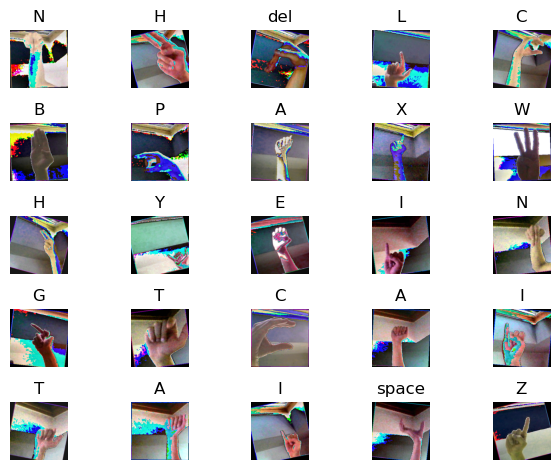

In [24]:
# loads one batch of training data
batch = next(iter(train_loader)) 

# creates a list of labels
labels_names = [chr(ord('A') + i) for i in range(26)]
labels_names.extend(["del","nothing","space"])

# displays grid of images and their labels
for i in range(25):
    
    image = transforms.ToPILImage()(batch[0][i])
    label = labels_names[batch[1][i].item()]
    resized_image = image.resize((256, 256))

    # plots the images and labels in a grid
    plt.subplot(5, 5, i + 1)
    plt.imshow(resized_image)
    plt.axis('off')
    plt.title(label )
    
plt.tight_layout()
# save the figure
plt.savefig("AlexNetTransforms.png")

In [25]:
learning_rate = 0.001
epochs = 30
alex_train_losses = []; alex_test_losses = []; 
alex_train_accuracies = []; alex_test_accuracies = []

# Perform workflow with AlexNet
alex = AlexNet().to(G_DEVICE)
optimizer = optim.Adam(alex.parameters(), lr = learning_rate)
loss_criteria = nn.CrossEntropyLoss().to(G_DEVICE)

In [26]:
# train AlexNet
for epoch in range(epochs):
    # get metrics
    train_loss, test_loss, train_accuracy, test_accuracy = train(alex, train_loader, test_loader, optimizer, loss_criteria, epoch)

    # populate arrays containing metric by epoch
    alex_train_losses.append(train_loss)
    alex_test_losses.append(test_loss)
    alex_train_accuracies.append(train_accuracy)
    alex_test_accuracies.append(test_accuracy)

Epoch 30: 100%|██████████| 544/544 [00:35<00:00, 15.18it/s]


### AlexNet Results

So it is clear to see that this model is much more powerful. The accuracy for the train and test data has improved drastically compared to the simpler LeNet5. Additionally the gap between the two subsets of the data is much smaller meaning that the model isn't as affected by the changes in data augmentation. Overall this model should be much better at our application of it on our webcam program we designed. A caviat to this model is that it took approximately eight times as long to train as it did for LeNet5.

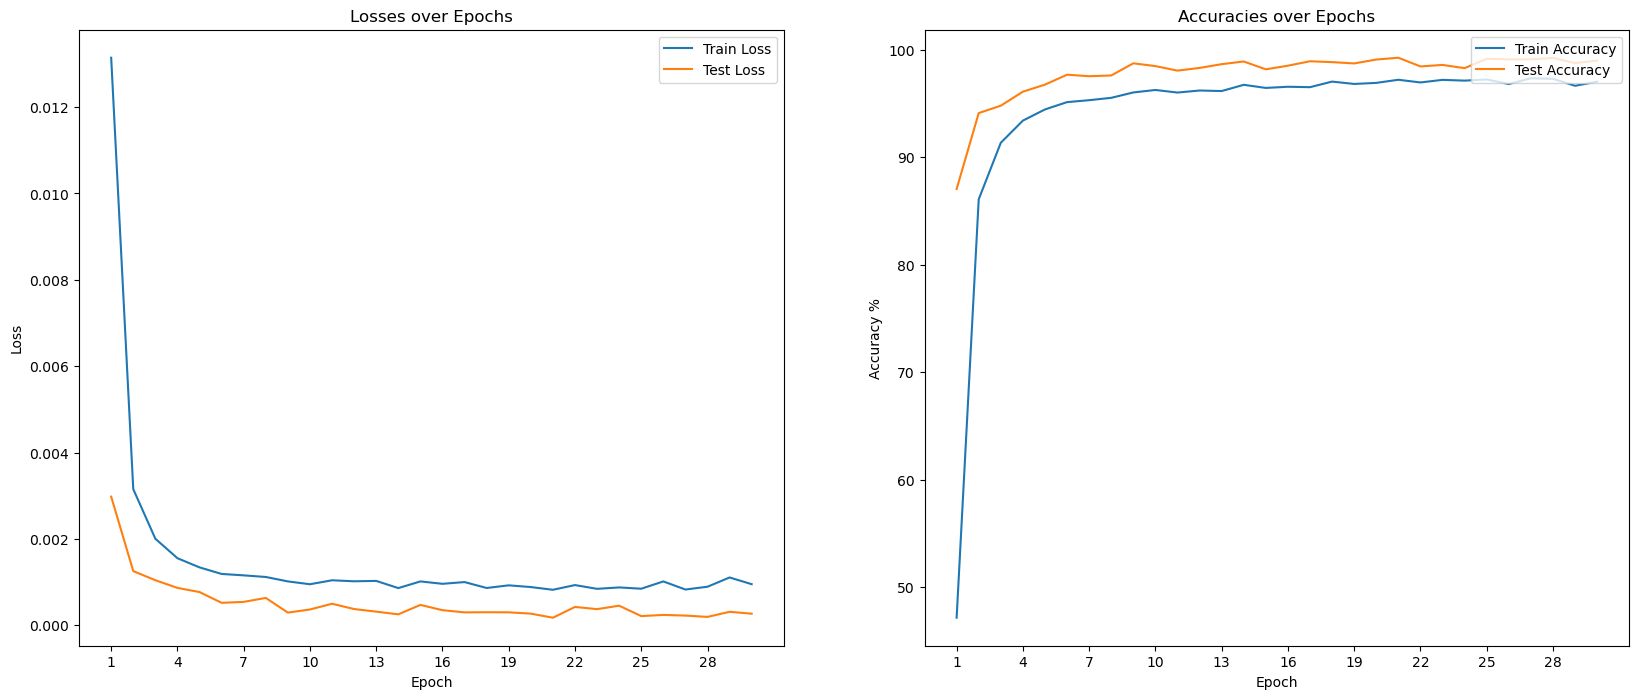

In [27]:
# save and show the plot for AlexNet
make_plots("AlexNet30EpochHistory.png", alex_train_losses, alex_test_losses, alex_train_accuracies, alex_test_accuracies)

In [28]:
# save the AlexNet model weights
save_model(alex, "AlexNet30Epoch.pth")

In [29]:
alex_accuracy, alex_loss = evaluate(alex, test_loader = test_loader, loss_criteria = loss_criteria)
print(f"ALEX ACCURACY {alex_accuracy} LOSS {alex_loss}")

ALEX ACCURACY 99.01 LOSS 0.00029493674045654307


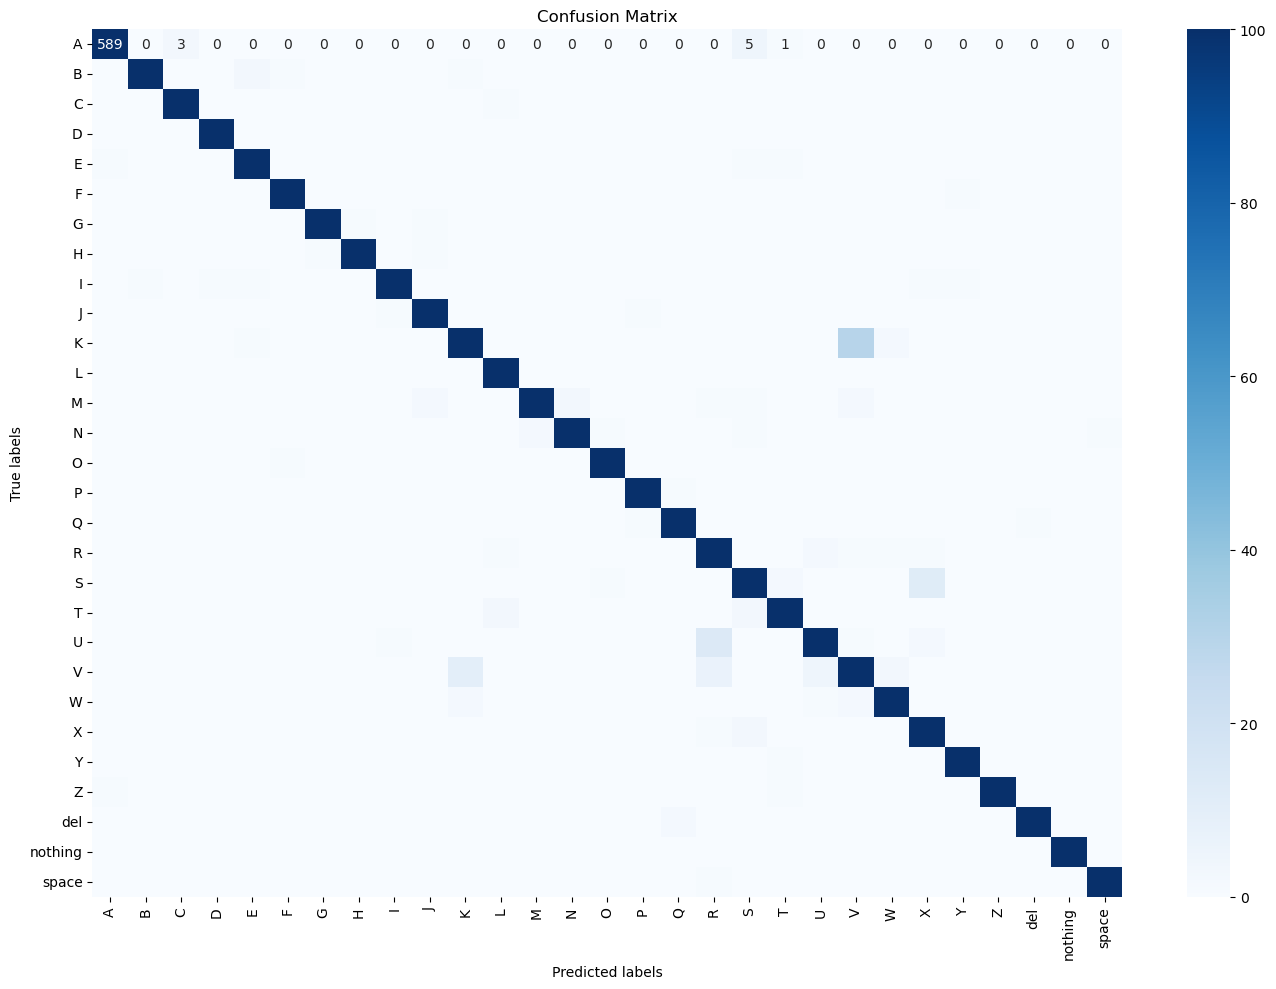

<Figure size 640x480 with 0 Axes>

In [30]:
# confusion matrix for AlexNet
create_confusion_matrix("AlexNet30EpochConfusion.png", alex, test_loader)

In [31]:
# delete AlexNet Model
del alex

# PIC 16B Final Project
### By:  Artem Kiryukhin and Karl Puttler

For this project we plan to use a dataset of 87,000 images of various American Sign Language hand signs to train a model which could accurately translate the hand signs to their appropriate meanings.
TODO: EXPAND THIS

Below we import the necessary libraries

In [1]:
from tqdm import tqdm
import numpy as np
import torch
# import torch.nn as nn
# from torchvision import transforms, datasets
# from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
# from PIL import Image
# from IPython.display import Image as Img
from sklearn.metrics import confusion_matrix
import seaborn as sns

from dataProcessing import *
from models import *

Since we wanted to work with our trained model and not necessarily train a new one every single time we worked in this file we implemented simple lambda functions to handle saving and loading the model parameters.

In [2]:
# set device to gpu if available and cpu if not
G_DEVICE            = torch.device("cuda") or torch.device("cpu")
G_BATCH_SIZE        = 128
G_NUM_WORKERS       = 16
G_TEST_IMG_PATH     = "ASL_Data/asl_alphabet_test/asl_alphabet_test"
G_TRAIN_IMG_PATH    = "ASL_Data/asl_alphabet_train/asl_alphabet_train"

In [3]:
# save and load model functions
save_model = lambda model, name: torch.save(model.state_dict(), name)
load_model = lambda model, name: model.load_state_dict(torch.load(name))

## LeNet

### Visualizing the Processed Images
The code below loads one batch from the train_loader object we defined in the dataProcessing file of this project. This object is created using the DataLoader class from PyTorch. Thanks to this class we do not need to worry about manually shuffling, batching, and loading the data. In addition to loading a single batch we define a list of label names to display instead of the numerical labels that the data has right now. Finally we itterate through a couple of samples and display the images that we will be inputting into our model. Notice the strange colors, these are due to standardization we performed on the pixel values of the images.

In [4]:
# load data for LeNet
train_loader, test_loader = split_dataloaders(G_TRAIN_IMG_PATH, train_size = 0.8, batch_size = G_BATCH_SIZE, num_workers = G_NUM_WORKERS, transform = train_transform_le)

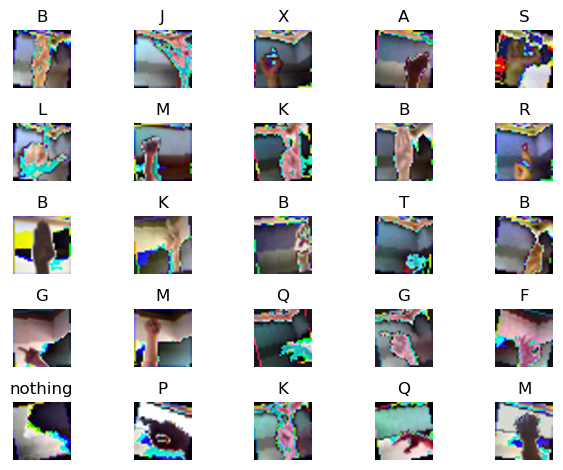

In [5]:
# load data to display
train_loader, test_loader = split_dataloaders(G_TRAIN_IMG_PATH, train_size = 0.8, batch_size = G_BATCH_SIZE, num_workers = G_NUM_WORKERS, transform = train_transform_le)

# loads one batch of training data
batch = next(iter(train_loader)) 

# creates a list of labels
labels_names = [chr(ord('A') + i) for i in range(26)]
labels_names.extend(["del","nothing","space"])

# displays grid of images and their labels
for i in range(25):
    
    image = transforms.ToPILImage()(batch[0][i])
    label = labels_names[batch[1][i].item()]
    resized_image = image.resize((256, 256))

    # plots the images and labels in a grid
    plt.subplot(5, 5, i + 1)
    plt.imshow(resized_image)
    plt.axis('off')
    plt.title(label )
    
plt.tight_layout()
# save the figure
plt.savefig("LeNetTransforms.png")

### Training and Accuracy Functions

Below are the functions we created for getting the accuracy of our model and to actually train the model. Let's walk through the inner mechanisms of each. 

The evaluate() function works by calculating how predictions are equal to the true label of the image for each batch, in other words how many did the model predict right. Then it simply divides this number by the amount of images are in the data set, multiplies it by a 100, and voila there is the model's accuracy.  Additionally this also gets the average loss function value per batch. We get the average since the train dataset has more batches and hence a cumulative function will produce artificially large loss values for the train data. Important note to use torch.no_grad() in order to make sure that none of our calculation interfere with gradient values later on.

The train model is slightly more complex, though it is nothing out of the ordinary. During the function runtime we unpack each batch into image pixels and labels, next we get the prediction of the current model and use those to calculate the loss. For the loss function we use CrossEntropyLoss which is standard for multi-class classification problems like we have here. After we get the loss we calculate the gradients with respect to each weight by calling loss.backward() and then perform an update rule via the optimizer class. 

In [6]:
def evaluate(model, test_loader, loss_criteria):
    """
    Tests the model's accuracy

    @params:
        model: pytorch nn.Module, model to evaluate
        test_loader: pytorch DataLoader, data to evaluate on
        loss_criteria: pytorch loss function, loss function

    @returns:
        (accuracy, test_loss) floats representing the percentage accuracy and average loss
    """
    
    # Sets model to eval mode
    model.eval()

    correct = 0
    test_loss = 0
    total_samples = 0
    
    with torch.no_grad():

        for data, label in test_loader:
            # Move data, label to device
            data = data.to(G_DEVICE)
            label = label.to(G_DEVICE)
            
            # Model's prediction
            output = model(data)
            
            # Calculate the number of correct responses in current batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(label==predicted).item()
            test_loss += loss_criteria(output, label).item()
            total_samples += data.size(0)
    
    # Get average loss
    test_loss = test_loss / total_samples
    # Get accuracy
    accuracy = round((100 * correct / len(test_loader.dataset)),2)
    
    return (accuracy, test_loss)

In [7]:
def train(model, train_loader, test_loader, optimizer, loss_criteria, epoch):
    """
    Trains the model parameters and returns average loss and percentage accuracy 
    
    @params:
        model - pytorch model to train
        train_loader - dataLoader object w/ training data
        test_loader - dataLoader object w/ testing data
        optimizer - pytorch optimizer object
        loss_criteria - pytorch loss criteria
        epoch - what the current epoch is
    
    @returns:
        (train_loss, test_loss, train_acc, test_acc) each a float 
    """
    
    # sets the model to training mode
    model.train()
    loss_tracker = 0
    correct = 0
    total_samples = 0
    
    # progress bar
    train_loader_iter = tqdm(train_loader, desc = f"Epoch {epoch + 1}")
    
    
    for data, label in train_loader_iter:

        data = data.to(G_DEVICE)
        label = label.to(G_DEVICE)

        # resets the gradients
        optimizer.zero_grad()
        
        # model's current prediction
        prediction = model(data)
        
        # tracks loss
        loss = loss_criteria(prediction, label)
        loss_tracker += loss.item()
        total_samples += data.size(0)
        
        # calculates gradient
        loss.backward()
        optimizer.step()
        
        # accuracy
        _, predicted = torch.max(prediction.data, 1)
        correct += torch.sum(label == predicted).item()
        
    # get training accuracy and average training loss
    train_acc = round((100 * correct / len(train_loader.dataset)), 2)
    train_loss =  loss_tracker / total_samples
    
    # get test accuracy and average loss
    test_acc, test_loss = evaluate(model, test_loader, loss_criteria)
        
    return (train_loss, test_loss, train_acc, test_acc)  

### Defining Parameters
Below we define our learning rate, epochs, and empty lists with loss and accuracy values. Additionally we initialize the model, optimizer, and the loss function.

Through trial and error of using a subset dataset we found that the more or less default learning rate of 0.01 was actually optimal for our training. Any larger values produced gradient steps that were too large and the model would overstep the global minimum. Additionally we chose the Adam optimizer since it helps use momentum to optimize the weights quicker, something we value greatly since our resources are limited and training models for a long time is quite constraining. 

In [8]:
learning_rate = 0.001
epochs = 30
lenet_train_losses = []; lenet_test_losses = []; 
lenet_train_accuracies = []; lenet_test_accuracies = []

# Perform workflow with LeNet
lenet = LeNet5().to(G_DEVICE)
optimizer = optim.Adam(lenet.parameters(), lr = learning_rate)
loss_criteria = nn.CrossEntropyLoss().to(G_DEVICE)

### Training the Model
This code simply calls the train function epoch amount of times and appends the accuracies and loss values. 

In [9]:
for epoch in range(epochs):
    # get metrics
    train_loss, test_loss, train_accuracy, test_accuracy = train(lenet, train_loader, test_loader, optimizer, loss_criteria, epoch)

    # populate arrays containing metric by epoch
    lenet_train_losses.append(train_loss)
    lenet_test_losses.append(test_loss)
    lenet_train_accuracies.append(train_accuracy)
    lenet_test_accuracies.append(test_accuracy)

Epoch 30: 100%|██████████| 544/544 [00:04<00:00, 112.49it/s]


In [10]:
def make_plots(file_name, train_losses, test_losses, train_accuracies, test_accuracies):
    """
    Creates a losses and accuracies plots and saves them to specified file name.

    @params:
        file_name: string, name with which to save plot 
        train_losses: list of floats
        test_losses: list of floats
        train_accuracies: list of floats
        test_accuracies: list of floats
    """
    # create subplots
    fig, ax = plt.subplots(1, 2, figsize = (20, 8))
    
    # plot the losses
    ax[0].plot(np.arange(1, epochs + 1), train_losses, label = "Train Loss")
    ax[0].plot(np.arange(1, epochs + 1), test_losses, label = "Test Loss")
    ax[0].set(title = "Losses over Epochs", ylabel = "Loss", xlabel = "Epoch")
    ax[0].set_xticks(np.arange(1, epochs + 1, 3));
    ax[0].legend(loc = "upper right")

    # plot the accuracies
    ax[1].plot(np.arange(1,epochs + 1), train_accuracies, label = "Train Accuracy")
    ax[1].plot(np.arange(1,epochs + 1), test_accuracies, label = "Test Accuracy")
    ax[1].set(title = "Accuracies over Epochs", ylabel = "Accuracy %", xlabel = "Epoch")
    ax[1].set_xticks(np.arange(1, epochs + 1, 3));
    ax[1].legend(loc = "upper right")

    # save plot
    plt.savefig(file_name, format="png")

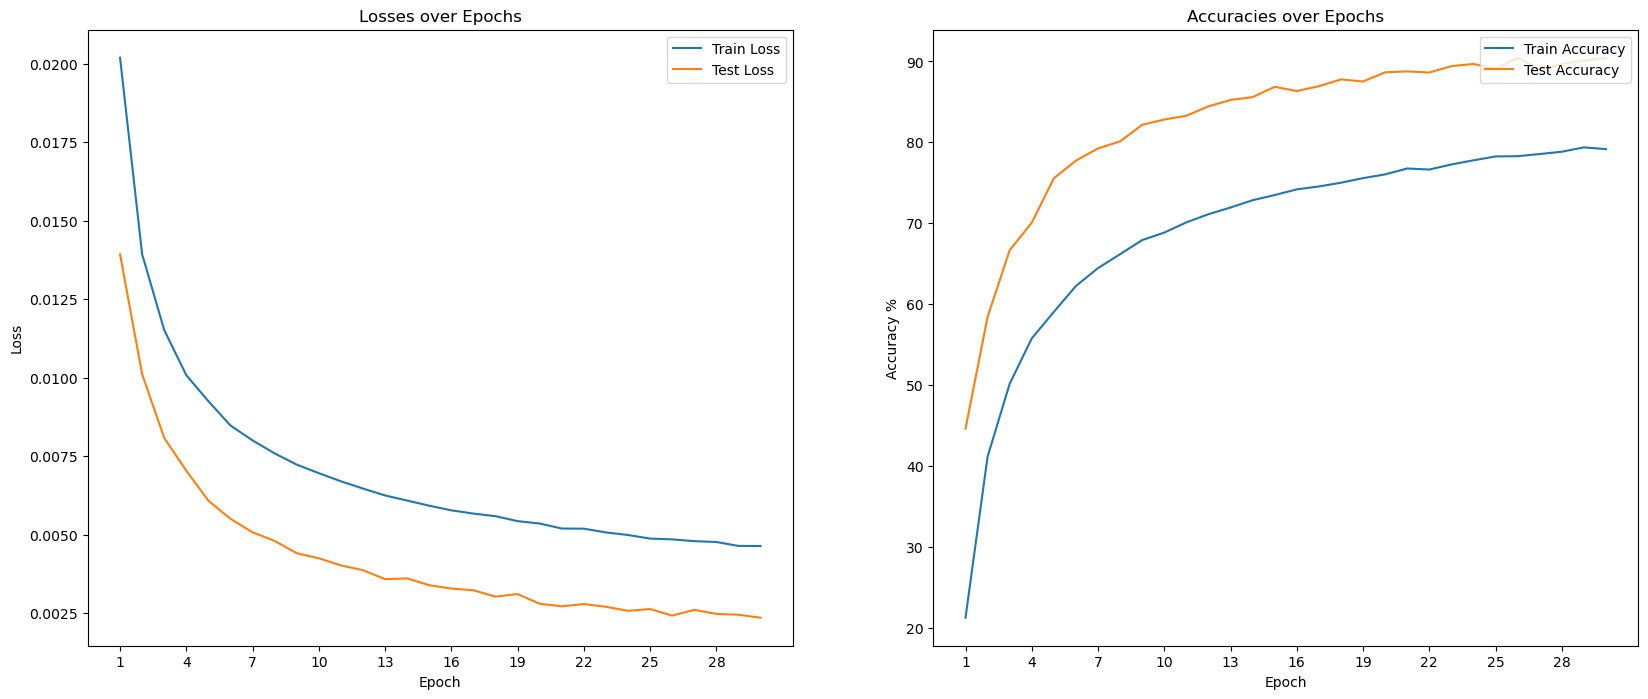

In [11]:
# save and show the plot for LeNet
make_plots("LeNet30EpochHistory.png", lenet_train_losses, lenet_test_losses, lenet_train_accuracies, lenet_test_accuracies)

The code below is for testing purposes rn. Also currently the validation set is more or less used as a test so maybe we abolish the test_loader all together...

In [12]:
# save the LeNet model weights
save_model(lenet, "LeNet30Epoch.pth")

In [13]:
lenet_accuracy, lenet_loss = evaluate(lenet, test_loader = test_loader, loss_criteria = loss_criteria)
print(f"LENET ACCURACY {lenet_accuracy} LOSS {lenet_loss}")

LENET ACCURACY 90.19 LOSS 0.00237689483672067


In [14]:
def create_confusion_matrix(file_name, model, test_loader):
    """ 
    Creates a confusion matrix given a model and a dataLoader object
    
    @params:
        model: pytorch nn.Module, model for which the matrix is made
        test_loader: pytorch dataloader, data with which the matrix is made
    """
    
    # sets the model to eval mode
    model.eval()

    labels_list = []
    predicted_list = []
    
    with torch.no_grad():
    
        for data, label in test_loader:
            # fills the labels and predictions
            labels_list.extend(label.numpy())
            # convert to device to calculate
            data = data.to(G_DEVICE)
            label = label.to(G_DEVICE)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            # convert back to cpu to do numpy
            predicted_list.extend(predicted.cpu().numpy())
            
    # construct the confusion matrix 
    conf_matrix = confusion_matrix(labels_list, predicted_list)
    
    # creates a sns heatmap with the conf matrix
    plt.figure(figsize=(14, 10))
    sns.heatmap(conf_matrix, annot = True, cmap = 'Blues', fmt = 'g', 
            xticklabels = labels_names, yticklabels = labels_names, vmax = 100)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # saves the figure
    plt.savefig(file_name, format = "png")

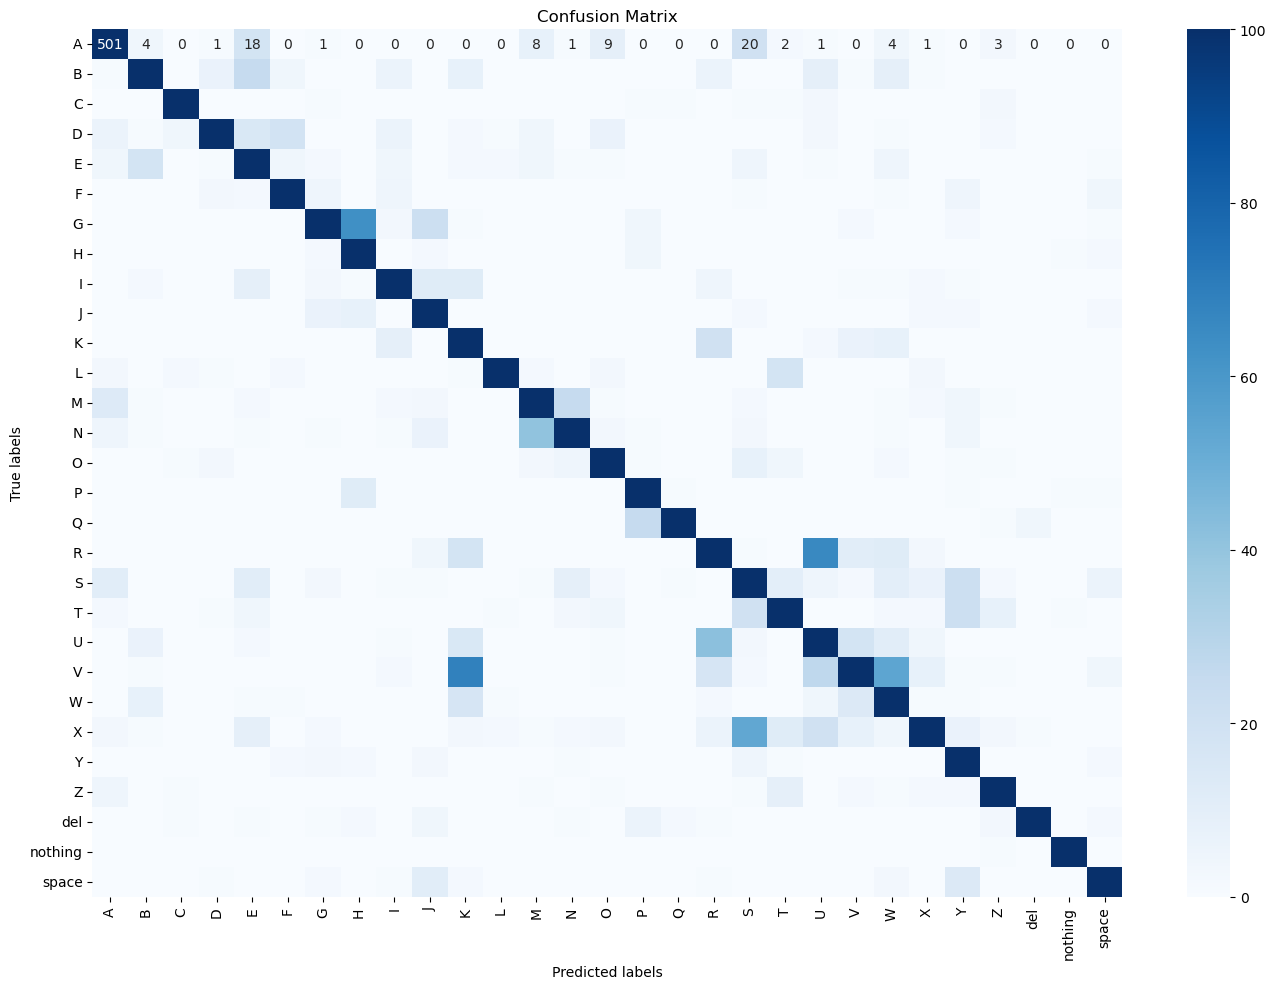

<Figure size 640x480 with 0 Axes>

In [15]:
# confusion matrix for LeNet
create_confusion_matrix("LeNet30EpochConfusion.png", lenet, test_loader)

In [16]:
# delete LeNet Model
del lenet

In [23]:
# load data for AlexNet
train_loader, test_loader = split_dataloaders(G_TRAIN_IMG_PATH, train_size = 0.8, batch_size = G_BATCH_SIZE, num_workers = G_NUM_WORKERS, transform = train_transform_alex)

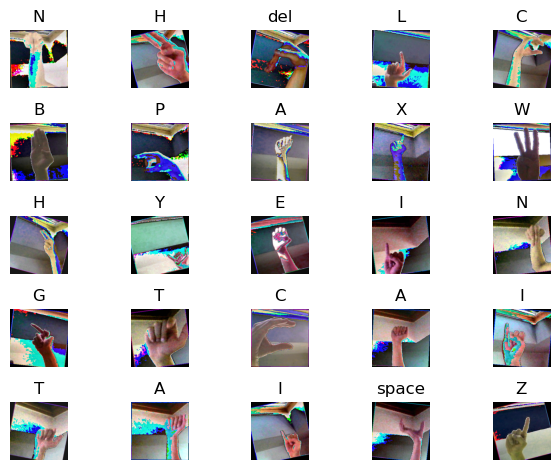

In [24]:
# loads one batch of training data
batch = next(iter(train_loader)) 

# creates a list of labels
labels_names = [chr(ord('A') + i) for i in range(26)]
labels_names.extend(["del","nothing","space"])

# displays grid of images and their labels
for i in range(25):
    
    image = transforms.ToPILImage()(batch[0][i])
    label = labels_names[batch[1][i].item()]
    resized_image = image.resize((256, 256))

    # plots the images and labels in a grid
    plt.subplot(5, 5, i + 1)
    plt.imshow(resized_image)
    plt.axis('off')
    plt.title(label )
    
plt.tight_layout()
# save the figure
plt.savefig("AlexNetTransforms.png")

In [25]:
learning_rate = 0.001
epochs = 30
alex_train_losses = []; alex_test_losses = []; 
alex_train_accuracies = []; alex_test_accuracies = []

# Perform workflow with AlexNet
alex = AlexNet().to(G_DEVICE)
optimizer = optim.Adam(alex.parameters(), lr = learning_rate)
loss_criteria = nn.CrossEntropyLoss().to(G_DEVICE)

In [26]:
# train AlexNet
for epoch in range(epochs):
    # get metrics
    train_loss, test_loss, train_accuracy, test_accuracy = train(alex, train_loader, test_loader, optimizer, loss_criteria, epoch)

    # populate arrays containing metric by epoch
    alex_train_losses.append(train_loss)
    alex_test_losses.append(test_loss)
    alex_train_accuracies.append(train_accuracy)
    alex_test_accuracies.append(test_accuracy)

Epoch 30: 100%|██████████| 544/544 [00:35<00:00, 15.18it/s]


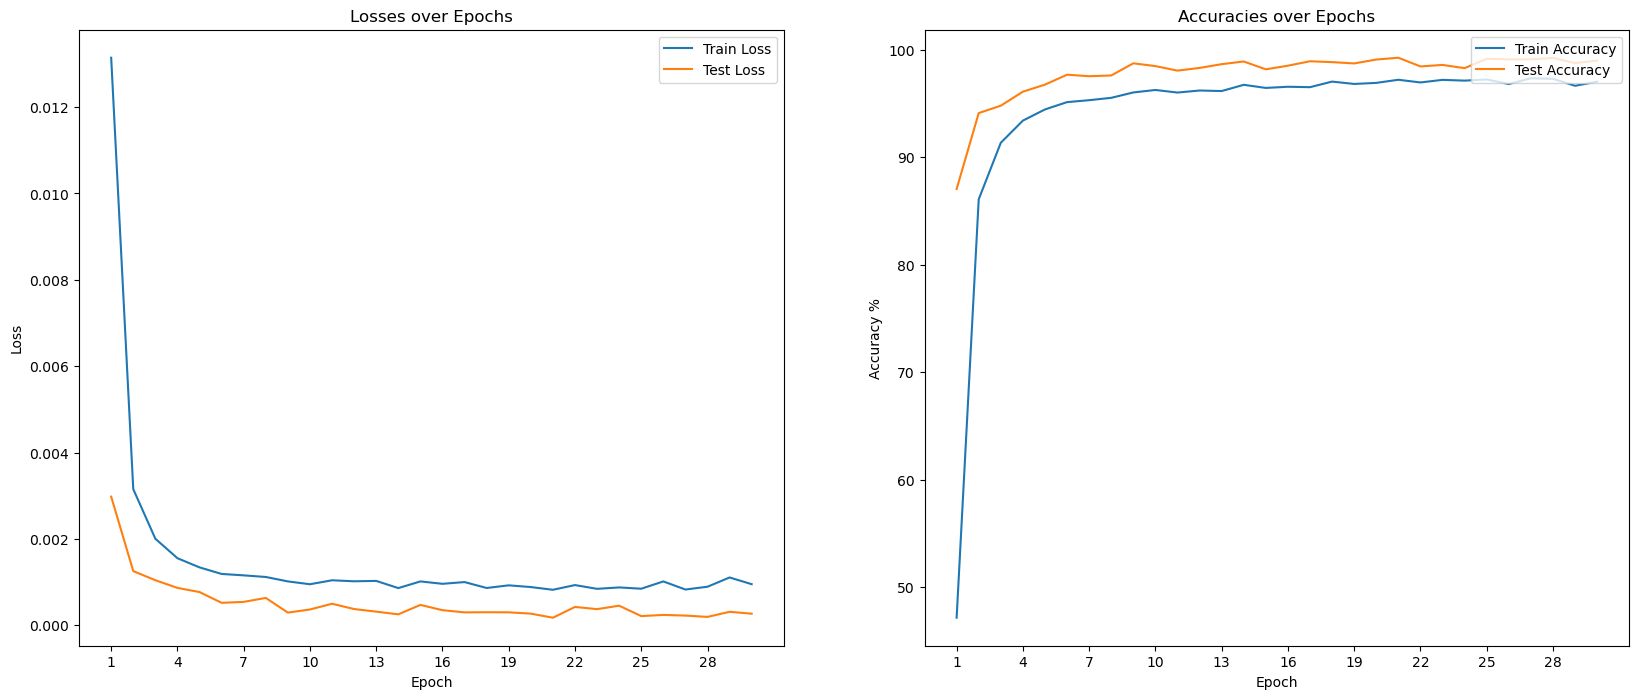

In [27]:
# save and show the plot for AlexNet
make_plots("AlexNet30EpochHistory.png", alex_train_losses, alex_test_losses, alex_train_accuracies, alex_test_accuracies)

In [28]:
# save the AlexNet model weights
save_model(alex, "AlexNet30Epoch.pth")

In [29]:
alex_accuracy, alex_loss = evaluate(alex, test_loader = test_loader, loss_criteria = loss_criteria)
print(f"ALEX ACCURACY {alex_accuracy} LOSS {alex_loss}")

ALEX ACCURACY 99.01 LOSS 0.00029493674045654307


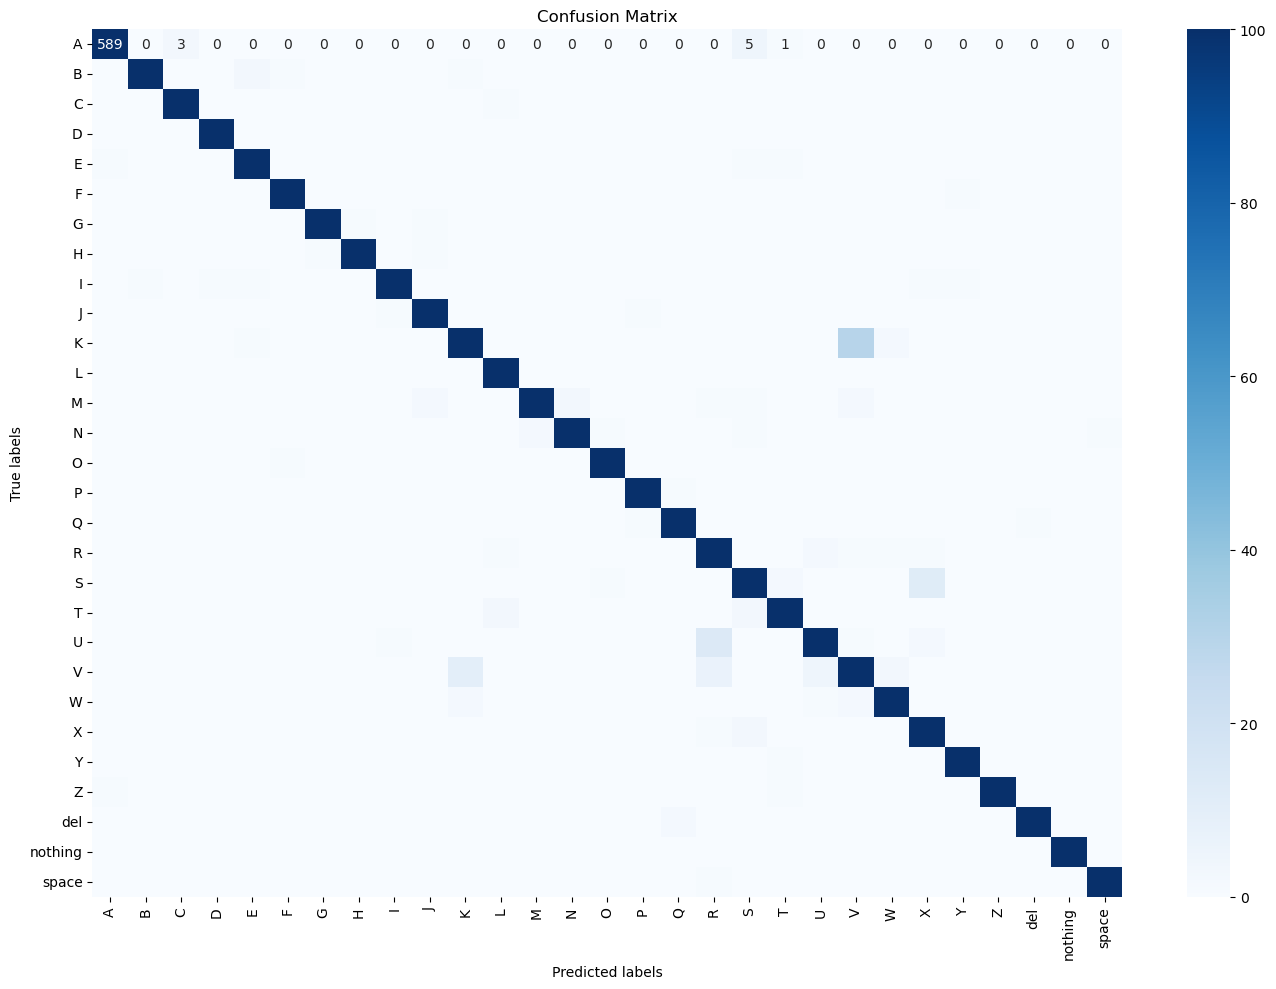

<Figure size 640x480 with 0 Axes>

In [30]:
# confusion matrix for AlexNet
create_confusion_matrix("AlexNet30EpochConfusion.png", alex, test_loader)

In [31]:
# delete AlexNet Model
del alex